In [ ]:
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import matplotlib.gridspec as gridspec
from sunpy.map import Map
from astropy.visualization import ImageNormalize, AsinhStretch

from torchmetrics import MeanAbsoluteError
from torchmetrics.regression import PearsonCorrCoef
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

from img2img.data.preprocess.sdo.preprocess_aia import NormalizeEditor
def denorm(x):
    x = NormalizeEditor(0, 14).inverse(x)
    return x

def norm(x):
    x = NormalizeEditor(0, 14).call(x)
    return x

In [ ]:
stage = "test"
real_root = Path("D:/data/aia_dataset") / stage
real_input_root = real_root / "input"
real_target_root = real_root / "target"

fake_target_root = Path("X:/jeon_mg/results/sdo/diffusion/ddpm/x0/logs/version_0/out") / stage

In [ ]:
real_input_files = sorted(real_input_root.glob("*.npz"))
len(real_input_files)

244

In [ ]:
idx = 0
real_input_file = real_input_files[idx]
print("Real Input")
print(real_input_file)
timestamp = real_input_file.stem[:19]
timestamp_str = timestamp[:10] + timestamp[10:].replace("-", ":")
print(timestamp)
print(timestamp_str)

Real Input
D:\data\aia_dataset\test\input\2020-09-01T00-00-00_171_304.npz
2020-09-01T00-00-00
2020-09-01T00:00:00


In [ ]:
real_target_files = sorted(real_target_root.glob("*.npz"))
len(real_target_files)

244

In [ ]:
real_target_file = real_target_files[idx]
assert real_target_file.stem[:19] == timestamp
print("Real Target")
print(real_target_file)

Real Target
D:\data\aia_dataset\test\target\2020-09-01T00-00-00_193.npz


In [ ]:
fake_target_files = sorted(fake_target_root.glob("*.npz"))
len(fake_target_files)

244

In [ ]:
fake_target_file = fake_target_files[idx]
assert fake_target_file.stem[:19] == timestamp
print("Fake Target")
print(fake_target_file)

Fake Target
X:\jeon_mg\results\sdo\diffusion\ddpm\x0\logs\version_0\out\test\2020-09-01T00-00-00_193_fake.npz


In [ ]:
real_input = np.load(real_input_file, allow_pickle=True)
real_target = np.load(real_target_file, allow_pickle=True)
fake_target = np.load(fake_target_file, allow_pickle=True)

In [ ]:
print(real_input["data"].shape, real_input["metas"].shape)
print(real_target["data"].shape, real_target["metas"].shape)
print(fake_target["data"].shape, fake_target["metas"].shape)

(2, 1024, 1024) (2,)
(1, 1024, 1024) (1,)
(1, 1024, 1024) (1,)


In [ ]:
real_inputs = [Map(data, meta) for data, meta in zip(real_input["data"], real_input["metas"])]
len(real_inputs)

2

In [ ]:
real_input_map_171 = real_inputs[0]
real_input_map_304 = real_inputs[1]

real_input_map_171 = denorm(real_input_map_171)
real_input_map_304 = denorm(real_input_map_304)

In [ ]:
real_target_map = Map(real_target["data"][0], real_target["metas"][0])
fake_target_map = Map(fake_target["data"][0], fake_target["metas"][0])

real_target_map = denorm(real_target_map)
fake_target_map = denorm(fake_target_map)

In [ ]:
norm171 = ImageNormalize(vmin=0, vmax=2000, stretch=AsinhStretch(0.02))
norm304 = ImageNormalize(vmin=0, vmax=2000, stretch=AsinhStretch(0.005))
norm193 = ImageNormalize(vmin=0, vmax=2000, stretch=AsinhStretch(0.04))

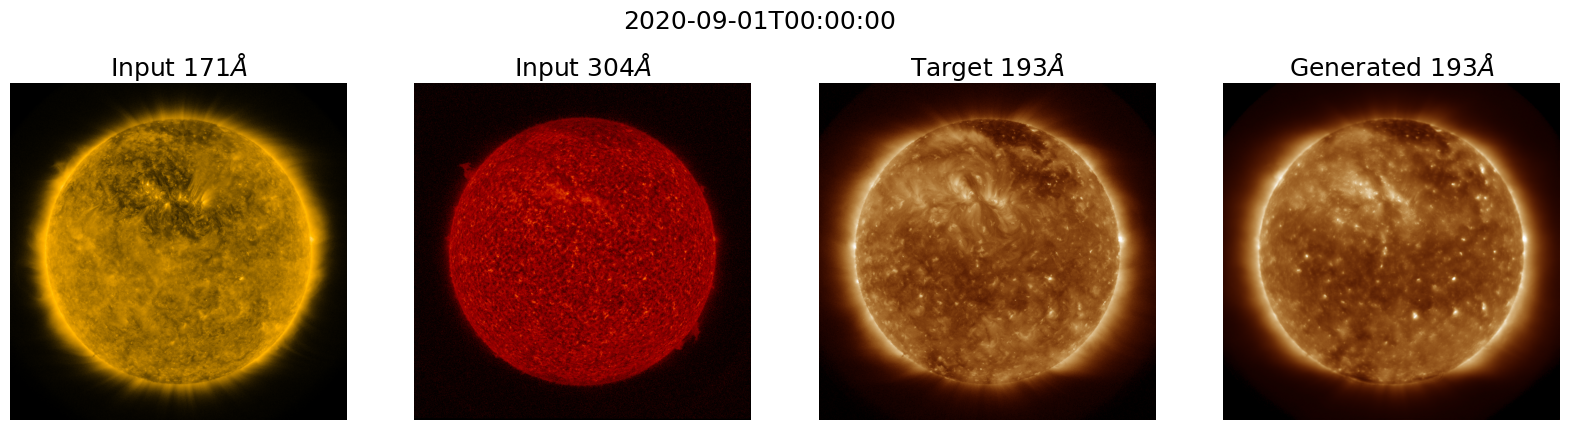

In [ ]:
plt.rcParams["font.size"] = 15

nrows = 1
ncols = 4

fig = plt.figure(figsize=(20, 5))

ax = fig.add_subplot(nrows, ncols, 1)
ax.imshow(real_input_map_171.data, cmap="sdoaia171", origin="lower", norm=norm171)
ax.axis("off")
ax.set_title("Input $171 \AA$")

ax = fig.add_subplot(nrows, ncols, 2)
ax.imshow(real_input_map_304.data, cmap="sdoaia304", origin="lower", norm=norm304)
ax.axis("off")
ax.set_title("Input $304 \AA$")

ax = fig.add_subplot(nrows, ncols, 3)
ax.imshow(real_target_map.data, cmap="sdoaia193", origin="lower", norm=norm193)
ax.axis("off")
ax.set_title("Target $193 \AA$")

ax = fig.add_subplot(nrows, ncols, 4)
ax.imshow(fake_target_map.data, cmap="sdoaia193", origin="lower", norm=norm193)
ax.axis("off")
ax.set_title("Generated $193 \AA$")

fig.suptitle(timestamp_str)
plt.show()

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(real_input_map_171.data, cmap="sdoaia171", origin="lower", norm=norm171)
ax.axis("off")
fig.savefig("real_input_map_171.png", bbox_inches="tight", pad_inches=0, dpi=300)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(real_input_map_304.data, cmap="sdoaia304", origin="lower", norm=norm304)
ax.axis("off")
fig.savefig("real_input_map_304.png", bbox_inches="tight", pad_inches=0, dpi=300)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(real_target_map.data, cmap="sdoaia193", origin="lower", norm=norm193)
ax.axis("off")
fig.savefig("real_target_map_193.png", bbox_inches="tight", pad_inches=0, dpi=300)
plt.close("all")

In [ ]:
def save_generated_map(map, filename):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(map.data, cmap="sdoaia193", origin="lower", norm=norm193)
    ax.axis("off")
    fig.savefig(filename, bbox_inches="tight", pad_inches=0, dpi=300)

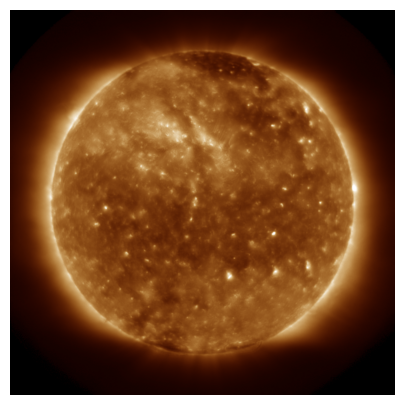

In [ ]:
save_generated_map(fake_target_map, "ddpm_x0.png")

In [ ]:
def get_metrics(real_map, fake_map, data_range=2, within_disk=True, return_mask=False):
    mae = MeanAbsoluteError()
    pcc = PearsonCorrCoef()                 
    psnr = PeakSignalNoiseRatio(data_range=data_range)             
    ssim = StructuralSimilarityIndexMeasure(data_range=data_range) 

    if within_disk:   
        Y, X = np.ogrid[:real_map.data.shape[0], :real_map.data.shape[1]]
        xc, yc = real_map.wcs.world_to_pixel(real_map.center)
        dist = np.sqrt((X-xc)**2 + (Y-yc)**2)
        mask = dist <= real_map.meta['r_sun']  # Mask points inside the circle
    else:
        mask = np.ones_like(real_map.data, dtype=bool)

    fake_data = torch.FloatTensor(fake_map.data*mask).unsqueeze(0).unsqueeze(0)
    real_data = torch.FloatTensor(real_map.data*mask).unsqueeze(0).unsqueeze(0)
    mae_value = mae(fake_data, real_data)
    pixel_to_pixel_cc = pcc(fake_data.flatten(), real_data.flatten())

    fake_data = torch.FloatTensor(norm(fake_map).data*mask).unsqueeze(0).unsqueeze(0)
    real_data = torch.FloatTensor(norm(real_map).data*mask).unsqueeze(0).unsqueeze(0)
    psnr_value = psnr(fake_data, real_data)
    ssim_value = ssim(fake_data, real_data)

    metrics = {
        "mae": mae_value,
        "pcc": pixel_to_pixel_cc,
        "psnr": psnr_value,
        "ssim": ssim_value,
    }
    if return_mask:
        return metrics, mask
    else:
        return metrics

In [ ]:
get_metrics(real_target_map, fake_target_map, within_disk=True)

{'mae': tensor(16.4487),
 'pcc': tensor(0.9076),
 'psnr': tensor(33.9367),
 'ssim': tensor(0.8045)}

In [ ]:
get_metrics(real_target_map, fake_target_map, within_disk=False)

{'mae': tensor(21.7474),
 'pcc': tensor(0.9313),
 'psnr': tensor(30.1375),
 'ssim': tensor(0.5992)}

In [ ]:
def get_mask_within_disk(smap, margin=100):
    Y, X = np.ogrid[:smap.data.shape[0], :smap.data.shape[1]]
    xc, yc = smap.wcs.world_to_pixel(smap.center)
    dist = np.sqrt((X-xc)**2 + (Y-yc)**2)
    mask = dist <= smap.meta['r_sun'] - margin  # Mask points inside the circle
    return mask

def get_random_coord_within_disk(smap, margin=100):
    mask = get_mask_within_disk(smap, margin)
    x_indices, y_indices = np.where(mask == 1)
    coordinates_within_disk = np.array(list(zip(x_indices, y_indices)))
    coord_idx = np.random.choice(coordinates_within_disk.shape[0], 1)
    coord = coordinates_within_disk[coord_idx].flatten()
    return coord

class ImageManager:
    def __init__(self, x, y, w, h, edgecolor="black", linewidth=2):
        self.x, self.y, self.w, self.h = x, y, w, h
        self.xmin, self.xmax = x, x+w
        self.ymin, self.ymax = y, y+h
        self.edgecolor = edgecolor
        self.linewidth = linewidth
    
    def add_image(self, ax, ax_zoom, map, title, cmap, norm):
        x, y, w, h = self.x, self.y, self.w, self.h
        xmin, xmax = self.xmin, self.xmax
        ymin, ymax = self.ymin, self.ymax
        edgecolor = self.edgecolor
        linewidth = self.linewidth

        ax.imshow(map.data, cmap=cmap, origin="lower", norm=norm)
        ax.set_title(title)
        ax.add_patch(plt.Rectangle((xmin, ymin), w, h, edgecolor=edgecolor, facecolor="none", lw=linewidth))

        ax_zoom.imshow(map.data[ymin:ymax, xmin:xmax], cmap=cmap, origin="lower", norm=norm)
        con = ConnectionPatch(xyA=(xmin, ymax-1), xyB=(0, h-1), coordsA="data", coordsB="data", axesA=ax, axesB=ax_zoom,
                            color=edgecolor, lw=linewidth)
        ax_zoom.add_artist(con)
        con = ConnectionPatch(xyA=(xmax, ymax-1), xyB=(w-1, h-1), coordsA="data", coordsB="data", axesA=ax, axesB=ax_zoom,
                            color=edgecolor, lw=linewidth)
        ax_zoom.add_artist(con)

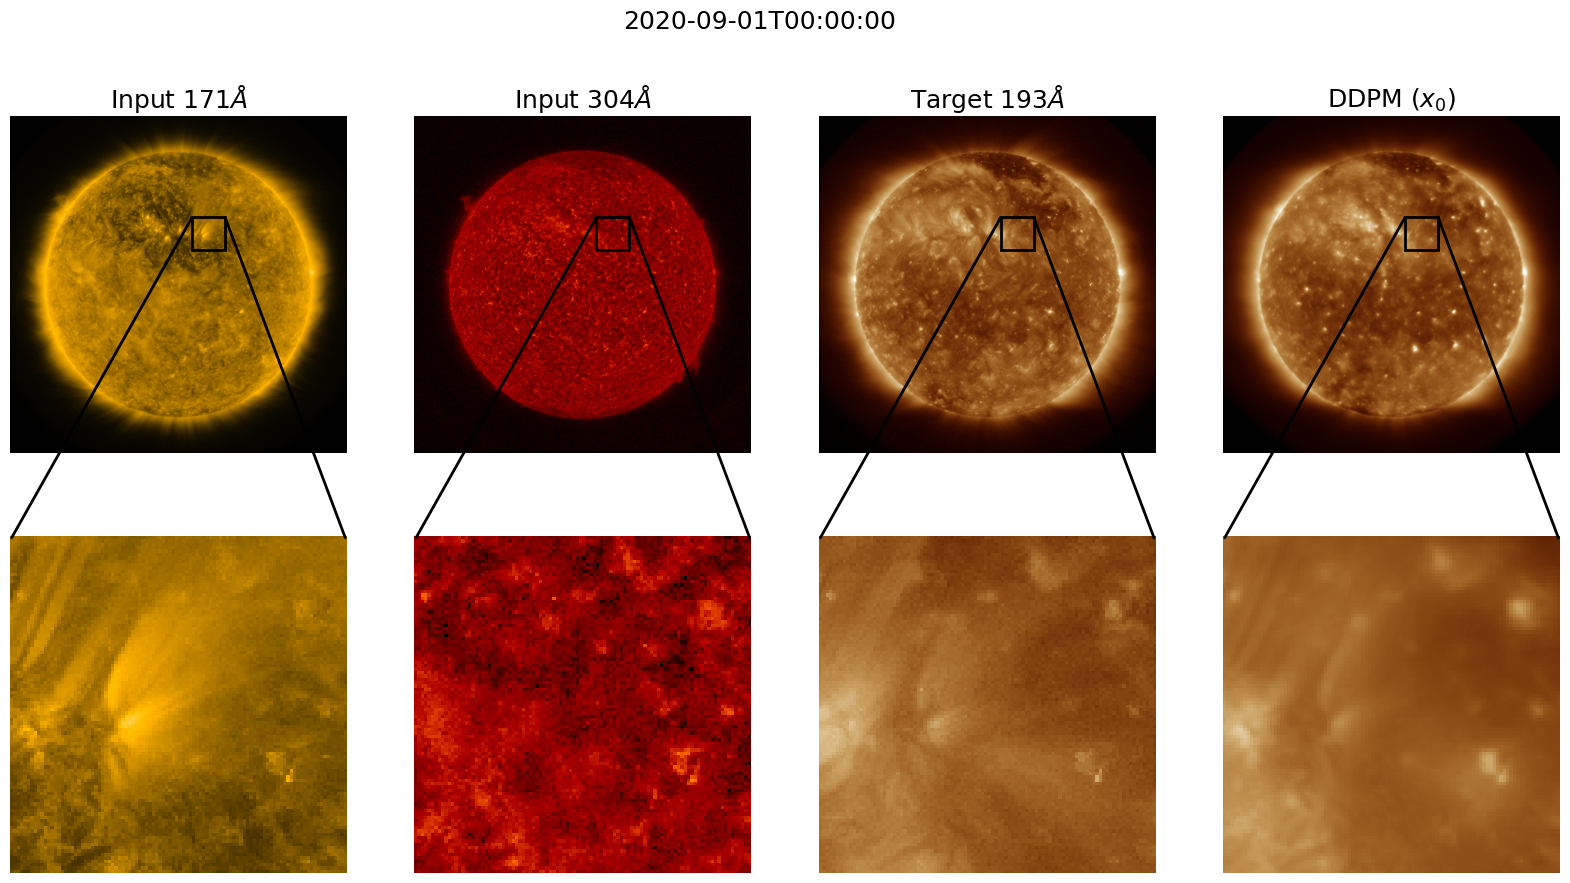

In [ ]:
plt.rcParams["font.size"] = 15

w = 100
h = w
coord = get_random_coord_within_disk(real_target_map, margin=w)
x = coord[0]
y = coord[1]

edgecolor="black"
linewidth=2

image_manager = ImageManager(x, y, w, h, edgecolor, linewidth)

nrows = 2
ncols = 4

fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(nrows, ncols)

for i in range(ncols):
    ax = fig.add_subplot(gs[0, i])
    ax.set_aspect('equal')
    ax.axis('off')

    ax_zoom = fig.add_subplot(gs[1, i])
    ax_zoom.set_aspect('equal')
    ax_zoom.axis('off')

    if i == 0:
        image_manager.add_image(ax, ax_zoom, real_input_map_171, "Input $171 \AA$", "sdoaia171", norm171)
    if i == 1:
        image_manager.add_image(ax, ax_zoom, real_input_map_304, "Input $304 \AA$", "sdoaia304", norm304)
    if i == 2:
        image_manager.add_image(ax, ax_zoom, real_target_map, "Target $193 \AA$", "sdoaia193", norm193)
    if i == 3:
        image_manager.add_image(ax, ax_zoom, fake_target_map, "DDPM ($x_0$)", "sdoaia193", norm193)

fig.suptitle(timestamp_str)
plt.show()